# 予備実験

## 発話分類

In [98]:
pip install keras-self-attention

  Created wheel for keras-self-attention: filename=keras_self_attention-0.47.0-py3-none-any.whl size=17287 sha256=9603916e2614a6a70e19b8da31d5065ad22563b4bf38d3bf7b1ebfadc9241638
  Stored in directory: /home/jovyan/.cache/pip/wheels/d3/10/ce/49936bed2a8c045ba90f16978392aa37d095aa6b4f5748ed22
Successfully built keras-self-attention
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
import numpy as np

In [97]:
import tensorflow_datasets as tfds
import tensorflow as tf

## データセット

In [4]:
train_dataset_path = "../Switchboard-Corpus/swda_data/train_set.txt"
test_dataset_path = "../Switchboard-Corpus/swda_data/test_set.txt"
val_dataset_path = "../Switchboard-Corpus/swda_data/val_set.txt"

In [5]:
train_dataset = []
f = open(train_dataset_path, "r", encoding='utf-8')
for row in f:
    train_dataset.append(row.strip())
f.close()

In [6]:
val_dataset = []
f = open(val_dataset_path, "r", encoding='utf-8')
for row in f:
    val_dataset.append(row.strip())
f.close()

In [7]:
test_dataset = []
f = open(test_dataset_path, "r", encoding='utf-8')
for row in f:
    test_dataset.append(row.strip())
f.close()

### データセット分割

In [8]:
## 訓練データ
train_utter_user = []
train_utter = []
train_utter_label = []

## テストデータ
test_utter_user = []
test_utter = []
test_utter_label = []

## 検証データ
val_utter_user = []
val_utter = []
val_utter_label = []

In [9]:
for j in train_dataset:
    for i,v in enumerate(j.split("|")):
        if i == 0:
            train_utter_user.append(v)
        elif i==1:
            train_utter.append(v)
        else:
            train_utter_label.append(v)
            
print("finish")

finish


In [10]:
for j in test_dataset:
    for i,v in enumerate(j.split("|")):
        if i == 0:
            test_utter_user.append(v)
        elif i==1:
            test_utter.append(v)
        else:
            test_utter_label.append(v)
            
print("finish")

finish


In [11]:
for j in val_dataset:
    for i,v in enumerate(j.split("|")):
        if i == 0:
            val_utter_user.append(v)
        elif i==1:
            val_utter.append(v)
        else:
            val_utter_label.append(v)
            
print("finish")

finish


### ラベルデータ数値化

In [12]:
label_path = "../Switchboard-Corpus/swda_data/metadata/labels.txt"
labels = []
f = open(label_path, "r", encoding='utf-8')
for row in f:
    labels.append(row.strip())
f.close()

In [13]:
label = {}
for i,v in enumerate(labels):
    label[v] = i

In [14]:
train_utter_labels = []
for i in train_utter_label:
    train_utter_labels.append(label[i])

In [15]:
test_utter_labels = []
for i in test_utter_label:
    test_utter_labels.append(label[i])

In [16]:
val_utter_labels = []
for i in val_utter_label:
    val_utter_labels.append(label[i])

## データセットをtensorflowに扱える形にする

In [17]:
train_data = tf.data.Dataset.from_tensor_slices((train_utter, train_utter_labels))
test_data = tf.data.Dataset.from_tensor_slices((test_utter, test_utter_labels))
val_data = tf.data.Dataset.from_tensor_slices((val_utter, val_utter_labels))

In [18]:
for i,v in train_data.take(10):
    print(i,v)

tf.Tensor(b'Okay.', shape=(), dtype=string) tf.Tensor(17, shape=(), dtype=int32)
tf.Tensor(b'So, What kind of experience do you, do you have, then with child care?', shape=(), dtype=string) tf.Tensor(9, shape=(), dtype=int32)
tf.Tensor(b'I guess, I think, uh, I wonder if that worked.', shape=(), dtype=string) tf.Tensor(13, shape=(), dtype=int32)
tf.Tensor(b'Does it say something?', shape=(), dtype=string) tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(b'I think it usually does.', shape=(), dtype=string) tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(b'You might try, uh,', shape=(), dtype=string) tf.Tensor(19, shape=(), dtype=int32)
tf.Tensor(b"I don't know,", shape=(), dtype=string) tf.Tensor(12, shape=(), dtype=int32)
tf.Tensor(b'hold it down a little longer,', shape=(), dtype=string) tf.Tensor(19, shape=(), dtype=int32)
tf.Tensor(b'and see if it, uh,', shape=(), dtype=string) tf.Tensor(19, shape=(), dtype=int32)
tf.Tensor(b'Okay', shape=(), dtype=string) tf.Tensor(4, shape=(), dtype=in

In [19]:
i,v = next(iter(train_data))
print(i,v)

tf.Tensor(b'Okay.', shape=(), dtype=string) tf.Tensor(17, shape=(), dtype=int32)


## トークナイザー

In [20]:
## ボキャブラリーリスト
vocabulary_set = set()
## トークナイザー
tokenizer = tfds.features.text.Tokenizer()

## 分かち書き
for text_tensor,_ in train_data:
    some_tokens = tokenizer.tokenize(text_tensor.numpy())
    vocabulary_set.update(some_tokens)
    
## ボキャブラリーリスト作成
vocab_size = len(vocabulary_set)

## encode生成

In [21]:
encoder = tfds.features.text.TokenTextEncoder(vocabulary_set)

In [22]:
def encode(token, label):
    token = encoder.encode(token.numpy())
    return token, label

@tf.function
def tf_encoder(utter, label):
    encoded_text, label = tf.py_function(encode,[utter, label],[tf.int64, tf.int32])
    encoded_text.set_shape([None])
    label.set_shape([])
    return encoded_text, label

"""
MAX_LENGTH = 40
def filter_max_length(x,y,max_length=MAX_LENGTH):
    return tf.logical_and(tf.size(x) <= max_length,
                        tf.size(y) <= max_length)
"""

'\nMAX_LENGTH = 40\ndef filter_max_length(x,y,max_length=MAX_LENGTH):\n    return tf.logical_and(tf.size(x) <= max_length,\n                        tf.size(y) <= max_length)\n'

## metrics

In [69]:
METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'),
      tf.keras.metrics.Accuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
]

## データ設計

In [23]:
max_len = 40

In [24]:
all_train_data_encode = train_data.map(tf_encoder)
all_test_data_encode = test_data.map(tf_encoder)
all_val_data_encode = val_data.map(tf_encoder)

In [25]:
utter_train_data = all_train_data_encode.padded_batch(64, padded_shapes=([None], []), drop_remainder=True)
utter_test_data = all_test_data_encode.padded_batch(64, padded_shapes=([None], []), drop_remainder=True)
utter_val_data = all_val_data_encode.padded_batch(64, padded_shapes=([None], []), drop_remainder=True)

In [26]:
for i,v in utter_train_data.take(10):
    print(i,v)

tf.Tensor(
[[13492     0     0 ...     0     0     0]
 [15216  2228  3140 ...     0     0     0]
 [20545 16199 20545 ...     0     0     0]
 ...
 [ 2971 19685  7800 ...     0     0     0]
 [ 2343 17762  2098 ...     0     0     0]
 [  316     0     0 ...     0     0     0]], shape=(64, 21), dtype=int64) tf.Tensor(
[17  9 13  6  0 19 12 19 19  4  6  1  0  0  0  2 11  4 10  0  0  0  0  1
  6 18 14  7  1  0  3  0  0  1  0  0  1  6  7  0  0  0  0  1  0 14  0  1
  0  0  3  0  0  1  0  0  5  5  0  1  0  0  0  1], shape=(64,), dtype=int32)
tf.Tensor(
[[ 2971  8328 17129 ...     0     0     0]
 [  316     0     0 ...     0     0     0]
 [ 1987  4163  2983 ...     0     0     0]
 ...
 [11682  2343  4561 ...     0     0     0]
 [ 5486     0     0 ...     0     0     0]
 [ 8328 19773 13933 ...     0     0     0]], shape=(64, 27), dtype=int64) tf.Tensor(
[16  4  0  3  0  6  7  0  1  2  0  4  0  3  2  4  2  1  2  1 13  7  0  1
 21  0  0  3  4  2  2  2  1  2 23 17  1  3  0  1  6  6 28  0  1  2  1  6

In [27]:
utter_train_data, utter_test_data, utter_val_data

(<PaddedBatchDataset shapes: ((64, None), (64,)), types: (tf.int64, tf.int32)>,
 <PaddedBatchDataset shapes: ((64, None), (64,)), types: (tf.int64, tf.int32)>,
 <PaddedBatchDataset shapes: ((64, None), (64,)), types: (tf.int64, tf.int32)>)

## モデル設計(RNN)

In [28]:
rnn_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.LSTM(64),
    
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [29]:
rnn_model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [30]:
history = rnn_model.fit(utter_train_data, epochs=10,
                    validation_data=utter_val_data, 
                    validation_steps=30)

Epoch 1/10
3006/3006 [==============================] - 211s 70ms/step - loss: -171.0589 - accuracy: 0.1976 - val_loss: -309.1272 - val_accuracy: 0.1766
Epoch 2/10
3006/3006 [==============================] - 216s 72ms/step - loss: -879.7972 - accuracy: 0.1982 - val_loss: -1072.3658 - val_accuracy: 0.1755
Epoch 3/10
3006/3006 [==============================] - 250s 83ms/step - loss: -2049.8381 - accuracy: 0.1921 - val_loss: -2051.0625 - val_accuracy: 0.1755
Epoch 4/10
3006/3006 [==============================] - 220s 73ms/step - loss: -3771.5759 - accuracy: 0.1921 - val_loss: -3312.4087 - val_accuracy: 0.1755
Epoch 5/10
3006/3006 [==============================] - 214s 71ms/step - loss: -5987.7651 - accuracy: 0.1921 - val_loss: -5530.4316 - val_accuracy: 0.1755
Epoch 6/10
3006/3006 [==============================] - 215s 72ms/step - loss: -8015.5977 - accuracy: 0.1921 - val_loss: -6451.9243 - val_accuracy: 0.1755
Epoch 7/10
3006/3006 [==============================] - 207s 69ms/step - 

## 可視化

In [31]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])
    plt.show()

### acc

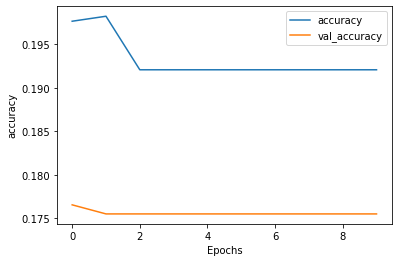

In [32]:
plot_graphs(history, 'accuracy')

### loss

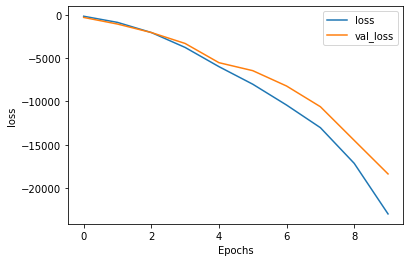

In [33]:
plot_graphs(history, 'loss')

## モデル(LSTM)

In [34]:
BATCH_SIZE = 64

In [41]:
X = tf.keras.Input(shape=(None,), batch_size=BATCH_SIZE)
embedded = tf.keras.layers.Embedding(encoder.vocab_size, 128)(X)
lstm = tf.keras.layers.LSTM(128, dropout=0.4, recurrent_dropout=0.4)(embedded)
fully_connected = tf.keras.layers.Dense(units=256, activation='relu')(lstm)
Y = tf.keras.layers.Dense(41, activation='sigmoid',name='final_layer')(fully_connected)
Rnn_Model = tf.keras.Model(inputs=X, outputs=Y)

Rnn_Model.compile(loss='sparse_categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(1e-4),metrics=['accuracy'])

In [42]:
Rnn_Model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(64, None)]              0         
_________________________________________________________________
embedding_3 (Embedding)      (64, None, 128)           2797312   
_________________________________________________________________
lstm_3 (LSTM)                (64, 128)                 131584    
_________________________________________________________________
dense_4 (Dense)              (64, 256)                 33024     
_________________________________________________________________
final_layer (Dense)          (64, 41)                  10537     
Total params: 2,972,457
Trainable params: 2,972,457
Non-trainable params: 0
_________________________________________________________________


In [43]:
history = Rnn_Model.fit(utter_train_data, epochs=10,
                    validation_data=utter_val_data, 
                    validation_steps=30)

Epoch 1/10
3006/3006 [==============================] - 444s 148ms/step - loss: 2.1266 - accuracy: 0.3777 - val_loss: 1.8014 - val_accuracy: 0.3859
Epoch 2/10
3006/3006 [==============================] - 486s 162ms/step - loss: 1.9461 - accuracy: 0.3946 - val_loss: 1.7952 - val_accuracy: 0.4062
Epoch 3/10
3006/3006 [==============================] - 425s 141ms/step - loss: 1.9068 - accuracy: 0.4023 - val_loss: 1.5573 - val_accuracy: 0.4141
Epoch 4/10
3006/3006 [==============================] - 14013s 5s/step - loss: 1.6852 - accuracy: 0.4081 - val_loss: 1.4867 - val_accuracy: 0.4156
Epoch 5/10
3006/3006 [==============================] - 15063s 5s/step - loss: 1.6362 - accuracy: 0.4666 - val_loss: 1.4630 - val_accuracy: 0.5380
Epoch 6/10
3006/3006 [==============================] - 441s 147ms/step - loss: 1.5806 - accuracy: 0.5561 - val_loss: 1.3935 - val_accuracy: 0.5432
Epoch 7/10
3006/3006 [==============================] - 3094s 1s/step - loss: 1.4212 - accuracy: 0.5670 - val_loss

## モデル(Attention)

In [44]:
class Attention(tf.keras.Model):
    def __init__(self, units):
        super(Attention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))
        attention_weights = tf.nn.softmax(self.V(score), axis=1)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [76]:
X = tf.keras.Input(shape=(None,), batch_size=BATCH_SIZE)
embedded = tf.keras.layers.Embedding(encoder.vocab_size, 64)(X)
lstm, forward_h, forward_c, backward_h, backward_c = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128,return_sequences=True,return_state=True, dropout=0.4, recurrent_dropout=0.4))(embedded)
state_h = tf.keras.layers.Concatenate()([forward_h, backward_h]) # 重みを結合
context,attention_weights = Attention(64)(lstm,state_h) # ここにAttentionレイヤを挟む
fully_connected = tf.keras.layers.Dense(units=128, activation='relu')(context)
Y = tf.keras.layers.Dense(41, activation='sigmoid',name='final_layer')(fully_connected)

Attention_Model = tf.keras.Model(inputs=X, outputs=Y)

Attention_Model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=METRICS)

In [77]:
Attention_Model.summary()

Model: "functional_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(64, None)]         0                                            
__________________________________________________________________________________________________
embedding_8 (Embedding)         (64, None, 64)       1398656     input_8[0][0]                    
__________________________________________________________________________________________________
bidirectional_4 (Bidirectional) [(64, None, 256), (N 197632      embedding_8[0][0]                
__________________________________________________________________________________________________
concatenate_4 (Concatenate)     (None, 256)          0           bidirectional_4[0][1]            
                                                                 bidirectional_4[0][3]

In [78]:
Attention_Model.fit(utter_train_data, epochs=1,
                    validation_data=utter_val_data, 
                    validation_steps=30)

ValueError: in user code:

    /opt/conda/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:806 train_function  *
        return step_function(self, iterator)
    /opt/conda/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /opt/conda/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /opt/conda/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /opt/conda/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    /opt/conda/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:789 run_step  **
        outputs = model.train_step(data)
    /opt/conda/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:748 train_step
        loss = self.compiled_loss(
    /opt/conda/lib/python3.8/site-packages/tensorflow/python/keras/engine/compile_utils.py:204 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    /opt/conda/lib/python3.8/site-packages/tensorflow/python/keras/losses.py:149 __call__
        losses = ag_call(y_true, y_pred)
    /opt/conda/lib/python3.8/site-packages/tensorflow/python/keras/losses.py:253 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    /opt/conda/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /opt/conda/lib/python3.8/site-packages/tensorflow/python/keras/losses.py:1535 categorical_crossentropy
        return K.categorical_crossentropy(y_true, y_pred, from_logits=from_logits)
    /opt/conda/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /opt/conda/lib/python3.8/site-packages/tensorflow/python/keras/backend.py:4687 categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)
    /opt/conda/lib/python3.8/site-packages/tensorflow/python/framework/tensor_shape.py:1134 assert_is_compatible_with
        raise ValueError("Shapes %s and %s are incompatible" % (self, other))

    ValueError: Shapes (64, 1) and (64, 41) are incompatible


In [50]:
l4 = Attention_Model.layers[4]
len(l4.get_weights())

6

In [52]:
"""
tf.keras.utils.plot_model(Attention_Model, show_shapes=True, show_layer_names=True, to_file='model.png')
from IPython.display import Image
Image(retina=False, filename='model.png')
"""

"\ntf.keras.utils.plot_model(Attention_Model, show_shapes=True, show_layer_names=True, to_file='model.png')\nfrom IPython.display import Image\nImage(retina=False, filename='model.png')\n"

In [54]:
i,v = next(iter(utter_train_data.take(1)))
print(i,v)

tf.Tensor(
[[13492     0     0 ...     0     0     0]
 [15216  2228  3140 ...     0     0     0]
 [20545 16199 20545 ...     0     0     0]
 ...
 [ 2971 19685  7800 ...     0     0     0]
 [ 2343 17762  2098 ...     0     0     0]
 [  316     0     0 ...     0     0     0]], shape=(64, 21), dtype=int64) tf.Tensor(
[17  9 13  6  0 19 12 19 19  4  6  1  0  0  0  2 11  4 10  0  0  0  0  1
  6 18 14  7  1  0  3  0  0  1  0  0  1  6  7  0  0  0  0  1  0 14  0  1
  0  0  3  0  0  1  0  0  5  5  0  1  0  0  0  1], shape=(64,), dtype=int32)


In [55]:
predict = Attention_Model.predict(i)